<a href="https://colab.research.google.com/github/LeevesC/DeepLearningAmt/blob/main/DL_assignment_2_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


## Investigate the dataset

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/dataset/diabetes_scale.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Outcome                   768 non-null    int64  
 1   Pregnancies               768 non-null    float64
 2   Glucose                   768 non-null    float64
 3   BloodPressure             768 non-null    float64
 4   SkinThickness             768 non-null    float64
 5   Insulin                   768 non-null    float64
 6   BMI                       768 non-null    float64
 7   DiabetesPedigreeFunction  768 non-null    float64
 8   Age                       759 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 54.1 KB


In [ ]:
data.head()

,Outcome,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,-1,-0.294118,0.487437,0.180328,-0.292929,-1.000000,0.001490,-0.531170,-0.033333
1,1,-0.882353,-0.145729,0.081967,-0.414141,-1.000000,-0.207153,-0.766866,-0.666667
2,-1,-0.058824,0.839196,0.049180,-1.000000,-1.000000,-0.305514,-0.492741,-0.633333
3,1,-0.882353,-0.105528,0.081967,-0.535354,-0.777778,-0.162444,-0.923997,-1.000000
4,-1,-1.000000,0.376884,-0.344262,-0.292929,-0.602837,0.284650,0.887276,-0.600000


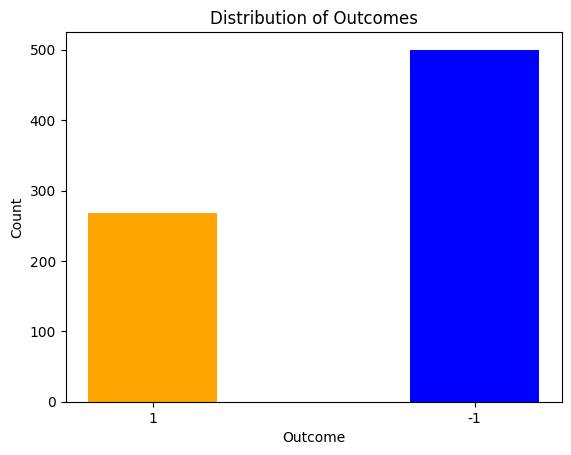

In [ ]:
# the numbers for the Outcome
outcome_counts = data['Outcome'].value_counts()

plt.bar(outcome_counts.index, outcome_counts.values, color=['blue', 'orange'])
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.title('Distribution of Outcomes')
plt.xticks(outcome_counts.index, labels=['-1', '1'])
plt.show()

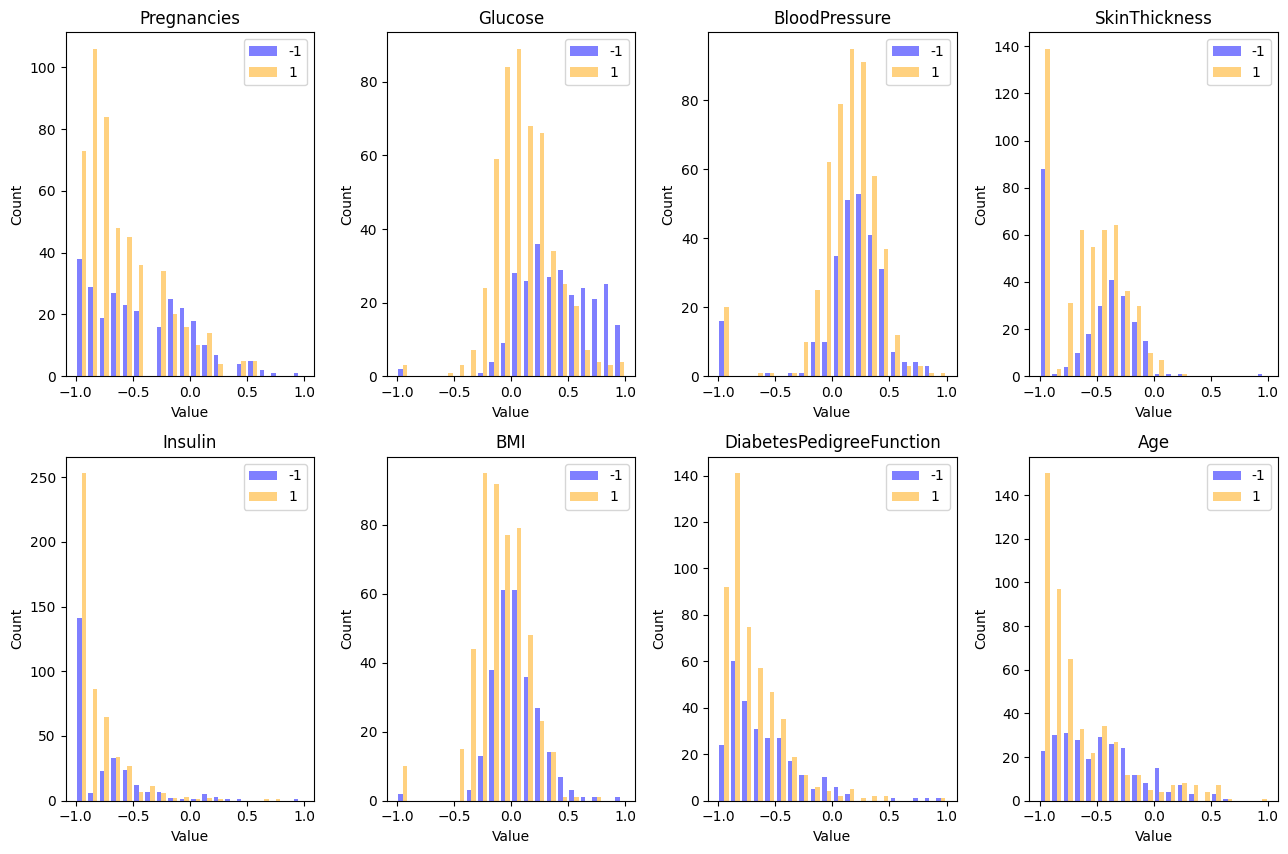

In [ ]:
# Each feature distributions by different outcomes
df_neg = data[data['Outcome'] == -1]
df_pos = data[data['Outcome'] == 1]
feature_columns = [col for col in data.columns if col != 'Outcome']
fig, axes = plt.subplots(2, 4, figsize=(13, 9))
axes = axes.flatten()
for i, feature in enumerate(feature_columns):
    ax = axes[i]
    ax.hist([df_neg[feature], df_pos[feature]], bins=20, alpha=0.5, label=['-1', '1'], color=['blue', 'orange'])
    ax.set_title(feature)
    ax.set_xlabel('Value')
    ax.set_ylabel('Count')
    ax.legend(loc='upper right')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Cleaning dataset

In [ ]:
#check null values
data.isnull().sum()

Outcome                     0
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         9
dtype: int64

In [ ]:
# check 0 value in the dataset
(data == 0).sum()

Outcome                     0
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64

In [ ]:
# drop rows that including invalid values
data = data.dropna()

In [ ]:
# change -1 in Outcome into 1
data['Outcome'] = data['Outcome'].replace(-1, 0)
data.head()

,Outcome,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0,-0.294118,0.487437,0.180328,-0.292929,-1.000000,0.001490,-0.531170,-0.033333
1,1,-0.882353,-0.145729,0.081967,-0.414141,-1.000000,-0.207153,-0.766866,-0.666667
2,0,-0.058824,0.839196,0.049180,-1.000000,-1.000000,-0.305514,-0.492741,-0.633333
3,1,-0.882353,-0.105528,0.081967,-0.535354,-0.777778,-0.162444,-0.923997,-1.000000
4,0,-1.000000,0.376884,-0.344262,-0.292929,-0.602837,0.284650,0.887276,-0.600000


In [ ]:
print(data['Outcome'].value_counts())

1    496
0    263
Name: Outcome, dtype: int64


## Implement Multilayer Perceptron

In [ ]:
# Function to create the MLP model
def create_mlp_model(input_dim, output_dim, num_neurons=10, num_hidden_layers=2, activation_function=nn.Sigmoid()):
    layers = []
    layers.append(nn.Linear(input_dim, num_neurons))
    layers.append(activation_function)

    for _ in range(num_hidden_layers):
        layers.append(nn.Linear(num_neurons, num_neurons))
        layers.append(activation_function)

    layers.append(nn.Linear(num_neurons, output_dim))
    layers.append(nn.Sigmoid())

    return nn.Sequential(*layers)

In [ ]:
# Function to train the MLP model
def train_mlp_model(df, num_neurons=10, num_hidden_layers=2, activation_function=nn.Sigmoid(),
                    learning_rate=0.01, batch_size=None, num_epochs=100, data_split=0.8):

    # Prepare the data
    X = df.drop('Outcome', axis=1).values
    y = df['Outcome'].values
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.FloatTensor(y).view(-1, 1)

    dataset = TensorDataset(X_tensor, y_tensor)
    train_size = int(data_split * len(dataset))
    val_size = len(dataset) - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    if batch_size is None:
        batch_size = len(train_dataset)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

    # Initialize the model, loss function and optimizer
    input_dim = X.shape[1]
    output_dim = 1
    model = create_mlp_model(input_dim, output_dim, num_neurons, num_hidden_layers, activation_function)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # To store metrics
    train_accuracies = []
    val_accuracies = []
    train_losses = []

    # Training loop
    for epoch in range(num_epochs):
        for batch in train_loader:
            X_batch, y_batch = batch
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

        # Record training metrics
        with torch.no_grad():
            y_train_pred = model(X_tensor)
            train_loss = criterion(y_train_pred, y_tensor).item()
            train_acc = accuracy_score(y, (y_train_pred > 0.5).numpy())
            train_losses.append(train_loss)
            train_accuracies.append(train_acc)
            # Validation metrics
            X_val, y_val = next(iter(val_loader))
            y_val_pred = model(X_val)
            val_acc = accuracy_score(y_val, (y_val_pred > 0.5).numpy())
            val_accuracies.append(val_acc)

        #print(f"Epoch {epoch+1}/{num_epochs} => "f"Train loss: {train_loss:.4f}, Train accuracy: {train_acc:.4f}, Validation accuracy: {val_acc:.4f}")

    # Plotting metrics
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.title("Training Loss")
    plt.plot(train_losses)

    plt.subplot(1, 2, 2)
    plt.title("Training and Validation Accuracy")
    plt.plot(train_accuracies, label='Train')
    plt.plot(val_accuracies, label='Validation')
    plt.legend()

    plt.show()

    #return model


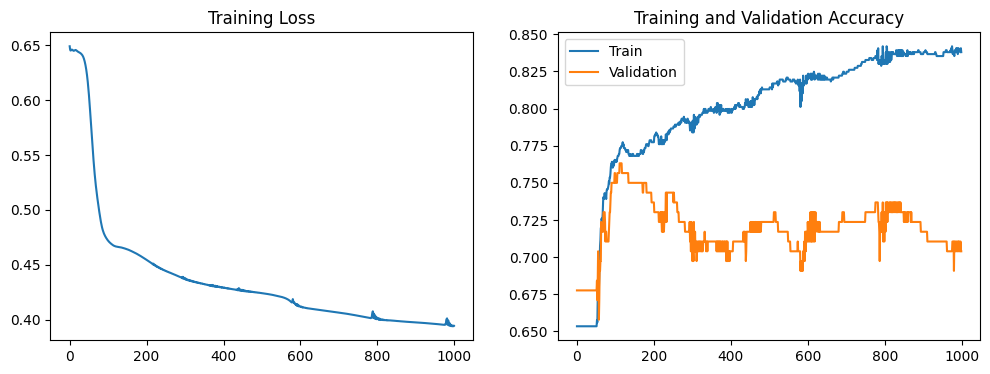

In [ ]:
train_mlp_model(df = data, num_neurons=10, num_hidden_layers=2, activation_function=nn.Sigmoid(),
                    learning_rate=0.01, batch_size=None, num_epochs=1000, data_split=0.8)

## Improvement

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
# Modified function to create the MLP model with Dropout
def create_mlp_model_with_dropout(input_dim, output_dim, num_neurons=10, num_hidden_layers=2, activation_function=nn.Sigmoid(), dropout_rate=0.5):
    layers = []
    layers.append(nn.Linear(input_dim, num_neurons))
    layers.append(activation_function)
    layers.append(nn.Dropout(dropout_rate))

    for _ in range(num_hidden_layers):
        layers.append(nn.Linear(num_neurons, num_neurons))
        layers.append(activation_function)
        layers.append(nn.Dropout(dropout_rate))

    layers.append(nn.Linear(num_neurons, output_dim))
    layers.append(nn.Sigmoid())

    return nn.Sequential(*layers)

In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm):
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [ ]:
# Function to train the MLP model
def train_mlp_model_dropout(df, num_neurons=10, num_hidden_layers=2, activation_function=nn.Sigmoid(),
                    learning_rate=0.01, batch_size=None, num_epochs=100, data_split=0.8, dropout_rate=0.5):

    # Prepare the data
    X = df.drop('Outcome', axis=1).values
    y = df['Outcome'].values
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.FloatTensor(y).view(-1, 1)

    dataset = TensorDataset(X_tensor, y_tensor)
    train_size = int(data_split * len(dataset))
    val_size = len(dataset) - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    if batch_size is None:
        batch_size = len(train_dataset)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

    # Initialize the model, loss function and optimizer
    input_dim = X.shape[1]
    output_dim = 1
    model = create_mlp_model_with_dropout(input_dim, output_dim, num_neurons, num_hidden_layers, activation_function, dropout_rate)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # To store metrics
    train_accuracies = []
    val_accuracies = []
    train_losses = []

    # Training loop
    for epoch in range(num_epochs):
        for batch in train_loader:
            X_batch, y_batch = batch
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

        # Record training metrics
        with torch.no_grad():
            y_train_pred = model(X_tensor)
            train_loss = criterion(y_train_pred, y_tensor).item()
            train_acc = accuracy_score(y, (y_train_pred > 0.5).numpy())
            train_losses.append(train_loss)
            train_accuracies.append(train_acc)
            # Validation metrics
            X_val, y_val = next(iter(val_loader))
            y_val_pred = model(X_val)
            val_acc = accuracy_score(y_val, (y_val_pred > 0.5).numpy())
            val_accuracies.append(val_acc)

        #print(f"Epoch {epoch+1}/{num_epochs} => "f"Train loss: {train_loss:.4f}, Train accuracy: {train_acc:.4f}, Validation accuracy: {val_acc:.4f}")

    # Plotting metrics
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.title("Training Loss")
    plt.plot(train_losses)

    plt.subplot(1, 2, 2)
    plt.title("Training and Validation Accuracy")
    plt.plot(train_accuracies, label='Train')
    plt.plot(val_accuracies, label='Validation')
    plt.legend()

    plt.show()

    return model, val_loader


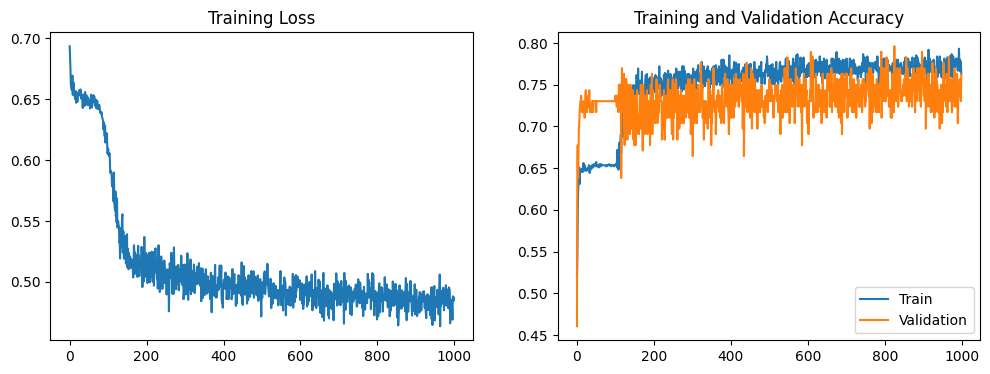

(Sequential(
   (0): Linear(in_features=8, out_features=10, bias=True)
   (1): Sigmoid()
   (2): Dropout(p=0.3, inplace=False)
   (3): Linear(in_features=10, out_features=10, bias=True)
   (4): Sigmoid()
   (5): Dropout(p=0.3, inplace=False)
   (6): Linear(in_features=10, out_features=10, bias=True)
   (7): Sigmoid()
   (8): Dropout(p=0.3, inplace=False)
   (9): Linear(in_features=10, out_features=1, bias=True)
   (10): Sigmoid()
 ),
 <torch.utils.data.dataloader.DataLoader at 0x7996e22e7dc0>)

In [ ]:
train_mlp_model_dropout(data, num_neurons=10, num_hidden_layers=2,
                        activation_function=nn.Sigmoid(), learning_rate=0.01,
                        batch_size=None, num_epochs=1000, data_split=0.8, dropout_rate=0.3)

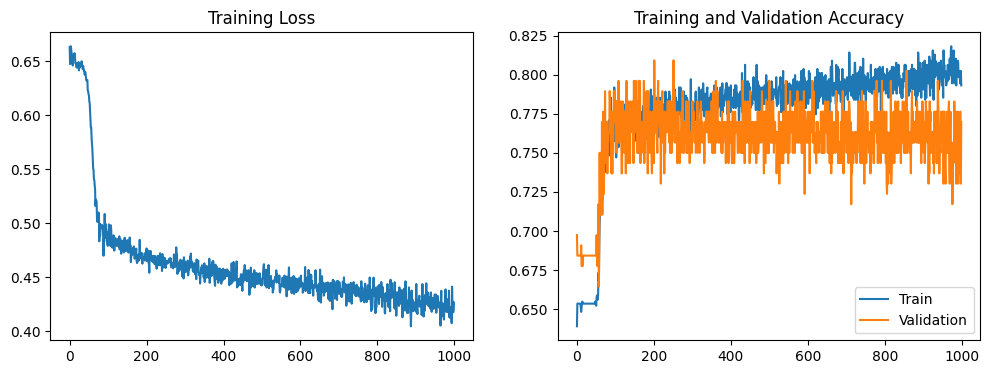

In [ ]:
trained_model, val_loader=train_mlp_model_dropout(data, num_neurons=50, num_hidden_layers=2,
                        activation_function=nn.Sigmoid(), learning_rate=0.01,
                        batch_size=None, num_epochs=1000, data_split=0.8, dropout_rate=0.2)

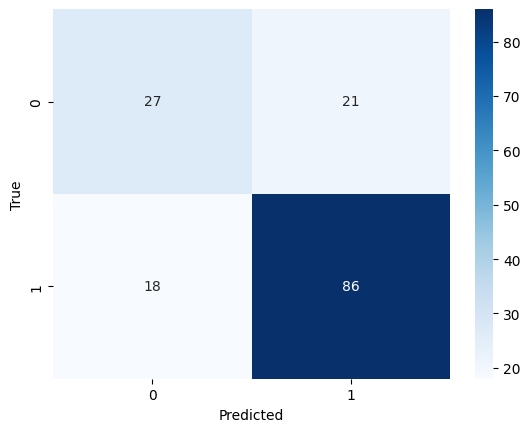

In [ ]:
with torch.no_grad():
    X_val, y_val = next(iter(val_loader))
    y_val_pred = trained_model(X_val)
    y_val_pred_class = (y_val_pred > 0.5).numpy()
    cm = confusion_matrix(y_val, y_val_pred_class)
    plot_confusion_matrix(cm)